Using device: cpu
Train samples: 60000, Test samples: 10000
Image shape: torch.Size([1, 28, 28])

ENTRAÎNEMENT AUTO-ENCODEUR
AE - Epoch [1/10], Loss: 0.0424
AE - Epoch [2/10], Loss: 0.0166
AE - Epoch [3/10], Loss: 0.0121
AE - Epoch [4/10], Loss: 0.0098
AE - Epoch [5/10], Loss: 0.0085
AE - Epoch [6/10], Loss: 0.0077
AE - Epoch [7/10], Loss: 0.0070
AE - Epoch [8/10], Loss: 0.0065
AE - Epoch [9/10], Loss: 0.0061
AE - Epoch [10/10], Loss: 0.0058


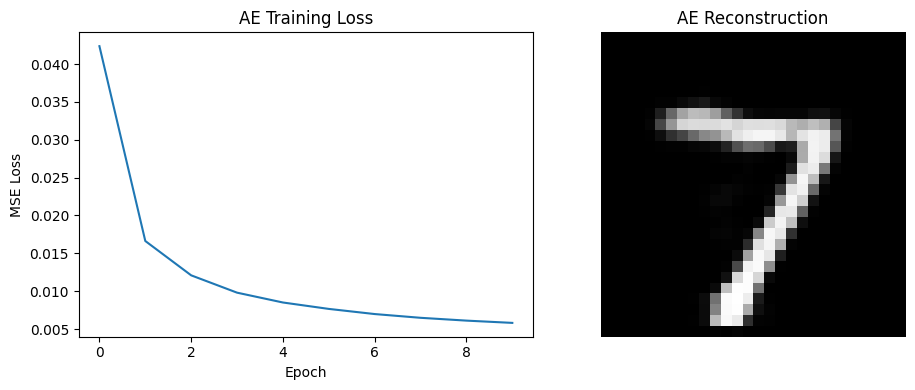


ENTRAÎNEMENT VARIATIONAL AUTO-ENCODEUR
VAE - Epoch [1/10], Total Loss: 22562.8414, BCE: 20582.6967, KLD: 1980.1447
VAE - Epoch [2/10], Total Loss: 16633.2110, BCE: 13823.8331, KLD: 2809.3779
VAE - Epoch [3/10], Total Loss: 15377.3095, BCE: 12306.1890, KLD: 3071.1205
VAE - Epoch [4/10], Total Loss: 14784.9951, BCE: 11612.9263, KLD: 3172.0688
VAE - Epoch [5/10], Total Loss: 14445.4568, BCE: 11215.9106, KLD: 3229.5462
VAE - Epoch [6/10], Total Loss: 14231.6802, BCE: 10964.8430, KLD: 3266.8371
VAE - Epoch [7/10], Total Loss: 14083.5094, BCE: 10790.9246, KLD: 3292.5848
VAE - Epoch [8/10], Total Loss: 13968.6262, BCE: 10661.9275, KLD: 3306.6987
VAE - Epoch [9/10], Total Loss: 13888.7823, BCE: 10569.7460, KLD: 3319.0363
VAE - Epoch [10/10], Total Loss: 13817.3704, BCE: 10494.5182, KLD: 3322.8522


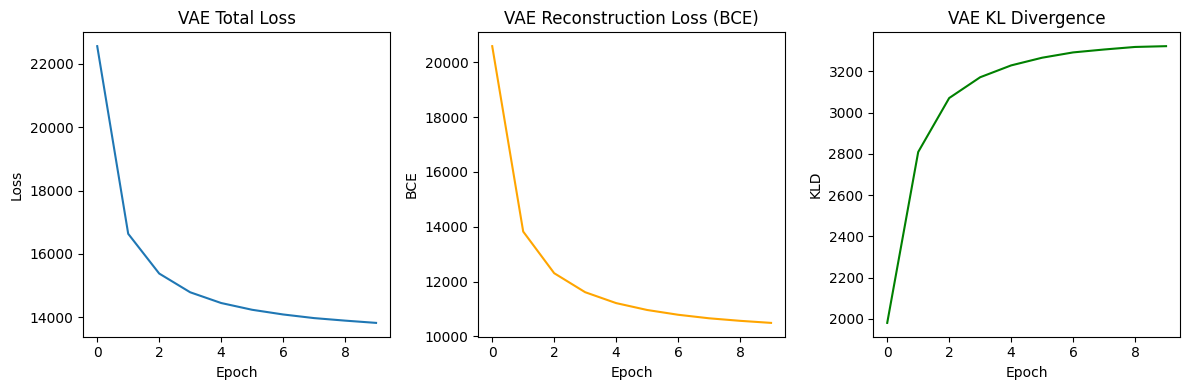


Visualisation espace latent AE:


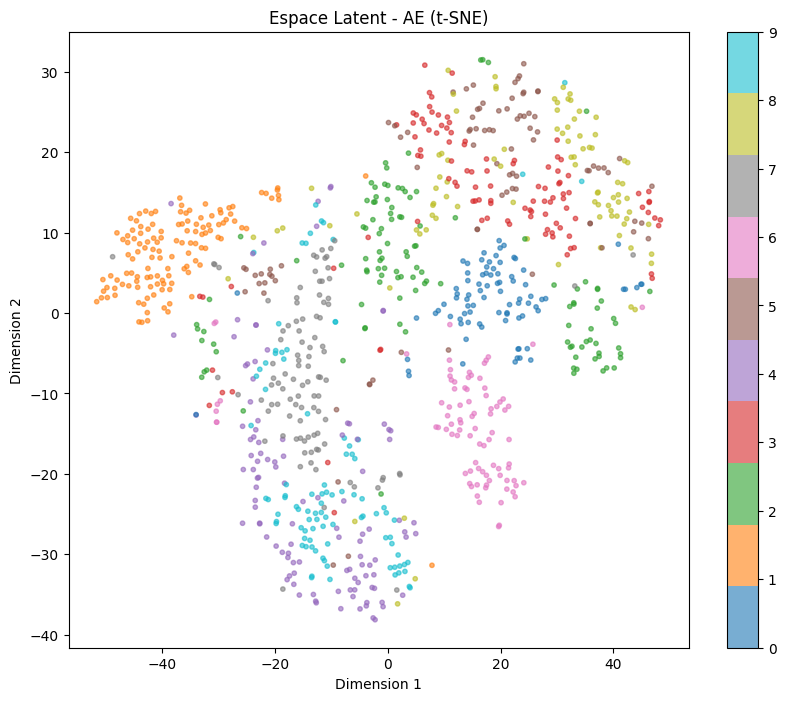


Visualisation espace latent VAE:


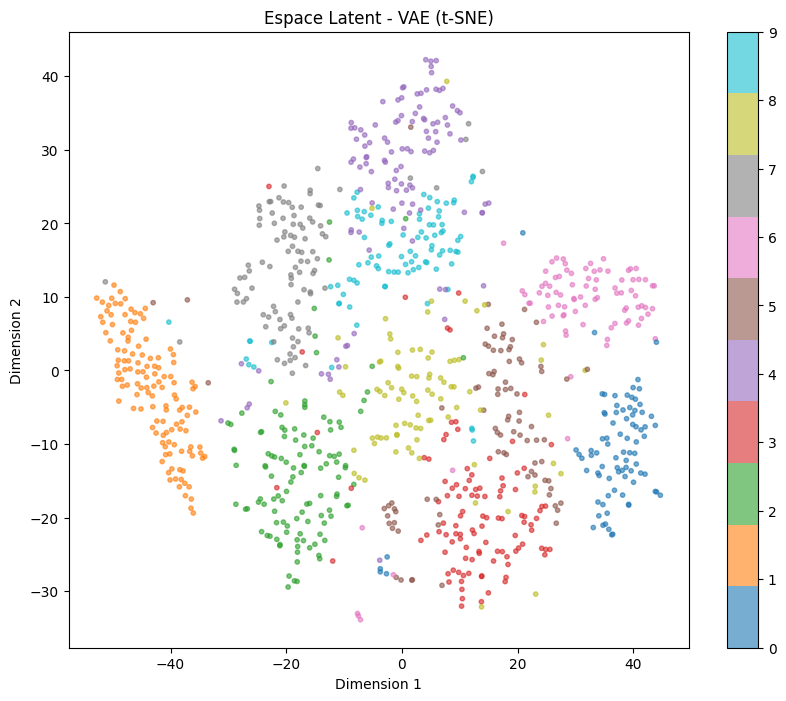


Génération d'images avec AE:


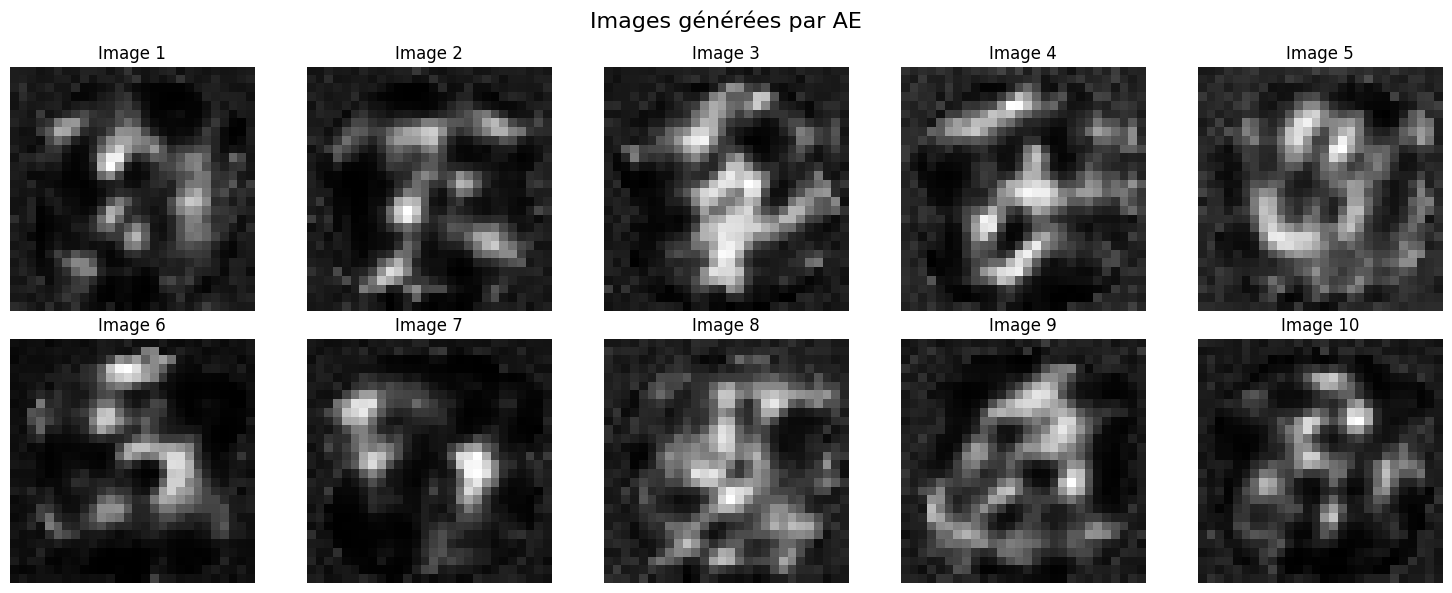


Génération d'images avec VAE:


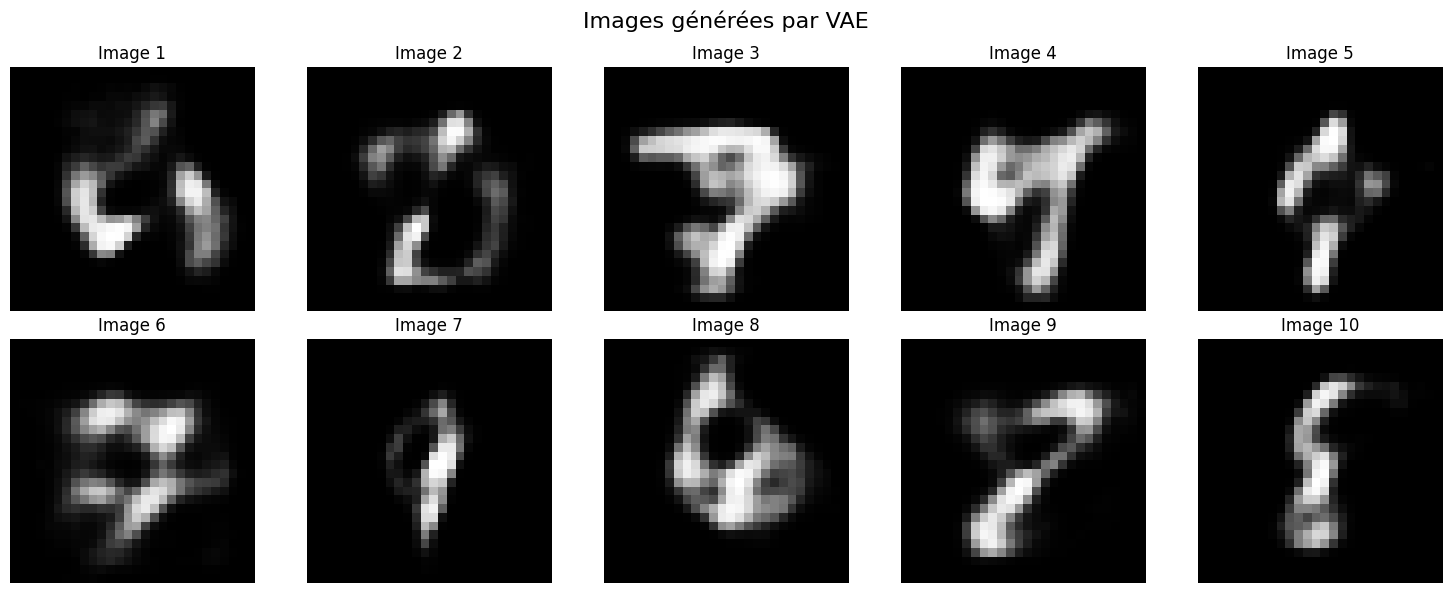


Comparaison des reconstructions AE vs VAE:


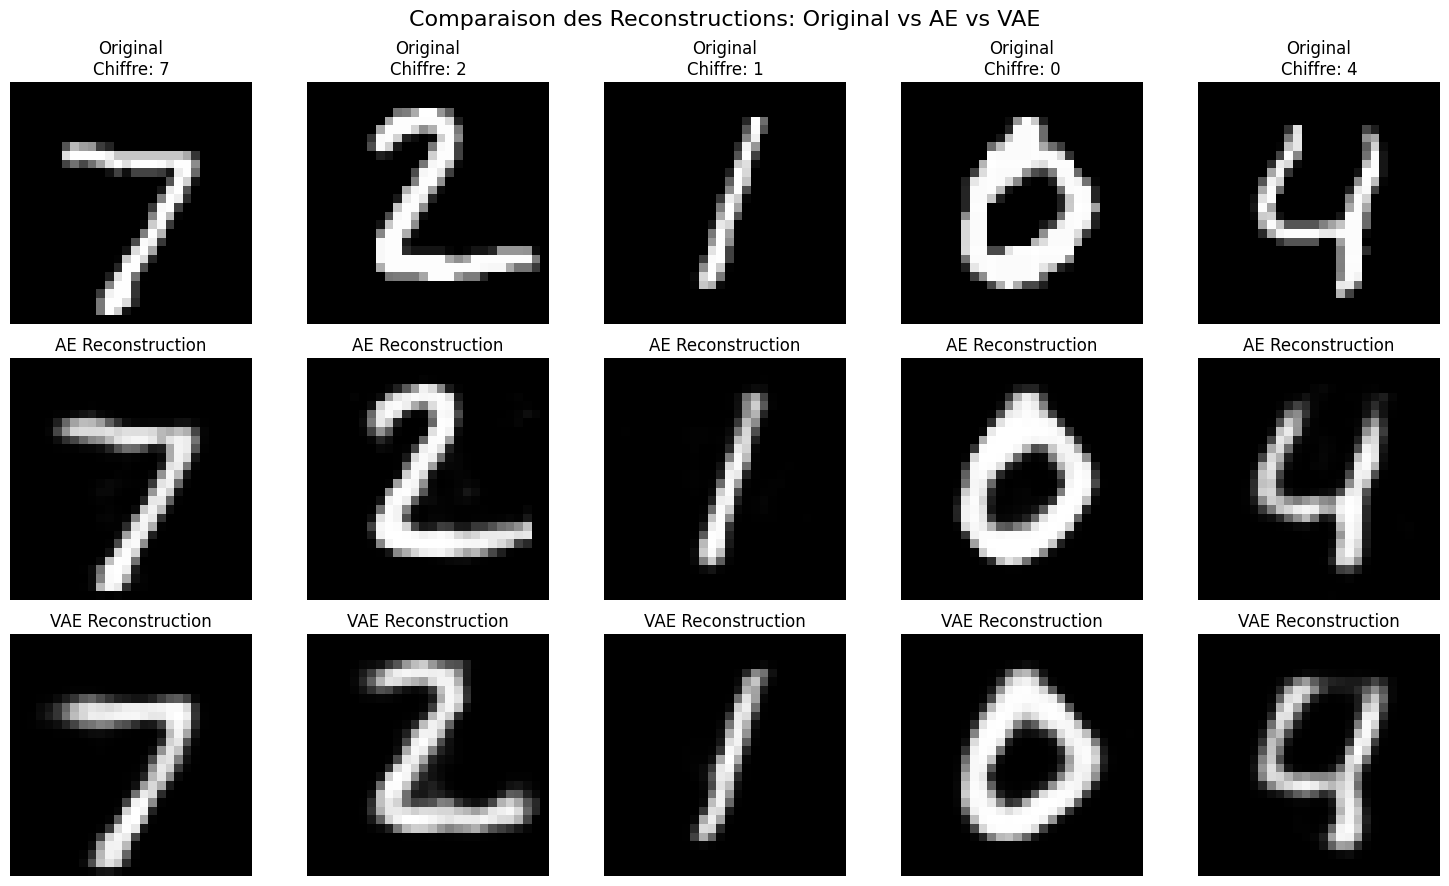


Interpolation dans l'espace latent VAE:


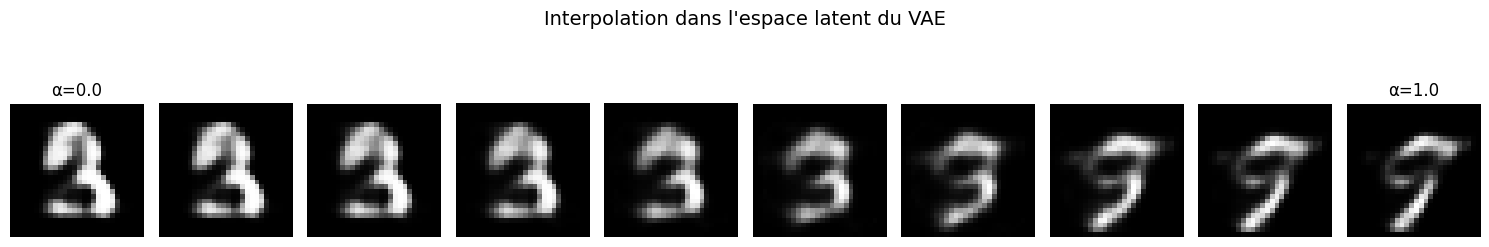

In [8]:
# ==================== INSTALLATION & IMPORTS ====================
!pip install torch torchvision matplotlib numpy scikit-learn -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import os

# ==================== CONFIGURATION ====================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== PARTIE 1: CHARGEMENT MNIST ====================
# Transformation SIMPLE (0 à 1)
transform = transforms.Compose([
    transforms.ToTensor()  # Convertit en tensor [0, 1]
])

# Téléchargement MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

# ==================== PARTIE 2: AUTO-ENCODEUR (AE) ====================
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=64):
        super(AutoEncoder, self).__init__()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )

        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Sortie entre 0 et 1
        )

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)
        encoded = self.encoder(x_flat)
        decoded = self.decoder(encoded)
        return decoded.view(batch_size, 1, 28, 28), encoded

# Entraînement AE
print("\n" + "="*50)
print("ENTRAÎNEMENT AUTO-ENCODEUR")
print("="*50)

model_ae = AutoEncoder().to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(model_ae.parameters(), lr=0.001)

ae_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    model_ae.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.to(device)

        optimizer_ae.zero_grad()
        reconstructed, _ = model_ae(data)
        loss = criterion_ae(reconstructed, data)
        loss.backward()
        optimizer_ae.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    ae_losses.append(avg_loss)
    print(f'AE - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Visualisation AE
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ae_losses)
plt.title('AE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

# Test reconstruction AE
model_ae.eval()
with torch.no_grad():
    test_data, _ = next(iter(test_loader))
    test_data = test_data[:8].to(device)
    recon_data, _ = model_ae(test_data)

    plt.subplot(1, 2, 2)
    for i in range(8):
        if i == 0:
            plt.imshow(recon_data[i].squeeze().cpu(), cmap='gray')
        if i == 7:
            break
    plt.title('AE Reconstruction')
    plt.axis('off')

plt.tight_layout()
plt.show()

# ==================== PARTIE 3: VARIATIONAL AUTO-ENCODEUR (VAE) ====================
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=32):
        super(VAE, self).__init__()

        # Encodeur
        self.encoder_fc1 = nn.Linear(input_dim, hidden_dim)
        self.encoder_fc2_mean = nn.Linear(hidden_dim, latent_dim)  # μ
        self.encoder_fc2_logvar = nn.Linear(hidden_dim, latent_dim)  # log(σ²)

        # Décodeur
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, input_dim)

        self.latent_dim = latent_dim

    def encode(self, x):
        h1 = F.relu(self.encoder_fc1(x))
        mu = self.encoder_fc2_mean(h1)
        logvar = self.encoder_fc2_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.decoder_fc1(z))
        return torch.sigmoid(self.decoder_fc2(h3))

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)

        mu, logvar = self.encode(x_flat)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)

        return recon.view(batch_size, 1, 28, 28), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (BCE)
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)

    # BCE avec clipping numérique
    BCE = F.binary_cross_entropy(recon_x_flat, x_flat, reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

print("\n" + "="*50)
print("ENTRAÎNEMENT VARIATIONAL AUTO-ENCODEUR")
print("="*50)

model_vae = VAE(latent_dim=32).to(device)
optimizer_vae = optim.Adam(model_vae.parameters(), lr=0.001)

vae_total_losses = []
vae_bce_losses = []
vae_kld_losses = []

for epoch in range(num_epochs):
    model_vae.train()
    total_loss = 0
    total_bce = 0
    total_kld = 0

    for data, _ in train_loader:
        data = data.to(device)

        optimizer_vae.zero_grad()
        recon_batch, mu, logvar = model_vae(data)

        loss, bce, kld = vae_loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer_vae.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

    avg_loss = total_loss / len(train_loader)
    avg_bce = total_bce / len(train_loader)
    avg_kld = total_kld / len(train_loader)

    vae_total_losses.append(avg_loss)
    vae_bce_losses.append(avg_bce)
    vae_kld_losses.append(avg_kld)

    print(f'VAE - Epoch [{epoch+1}/{num_epochs}], Total Loss: {avg_loss:.4f}, '
          f'BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}')

# Visualisation VAE
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(vae_total_losses)
plt.title('VAE Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(vae_bce_losses, color='orange')
plt.title('VAE Reconstruction Loss (BCE)')
plt.xlabel('Epoch')
plt.ylabel('BCE')

plt.subplot(1, 3, 3)
plt.plot(vae_kld_losses, color='green')
plt.title('VAE KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('KLD')

plt.tight_layout()
plt.show()

# ==================== PARTIE 4: VISUALISATION ESPACE LATENT ====================
def visualize_latent_space(model, dataloader, device, model_type='ae', n_samples=1000):
    """Visualise l'espace latent avec t-SNE"""
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)

            if model_type.lower() == 'ae':
                _, latent = model(data)
            elif model_type.lower() == 'vae':
                mu, _ = model.encode(data.view(data.size(0), -1))
                latent = mu
            else:
                raise ValueError("model_type doit être 'ae' ou 'vae'")

            latents.append(latent.cpu().numpy())
            labels.append(target.numpy())

            # Limiter le nombre d'échantillons pour t-SNE
            if len(np.concatenate(latents)) >= n_samples:
                break

    latents = np.concatenate(latents)[:n_samples]
    labels = np.concatenate(labels)[:n_samples]

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    latents_2d = tsne.fit_transform(latents)

    # Visualisation
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1],
                         c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(f'Espace Latent - {model_type.upper()} (t-SNE)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

print("\nVisualisation espace latent AE:")
visualize_latent_space(model_ae, test_loader, device, 'ae', n_samples=1000)

print("\nVisualisation espace latent VAE:")
visualize_latent_space(model_vae, test_loader, device, 'vae', n_samples=1000)

# ==================== PARTIE 5: GÉNÉRATION D'IMAGES ====================
def generate_images(model, num_images=10, model_type='ae'):
    """Génère de nouvelles images"""
    model.eval()

    with torch.no_grad():
        if model_type.lower() == 'ae':
            # Pour AE: vecteurs aléatoires dans l'espace latent
            z = torch.randn(num_images, 64).to(device)
            generated = model.decoder(z)
        elif model_type.lower() == 'vae':
            # Pour VAE: échantillonner de N(0,1)
            z = torch.randn(num_images, 32).to(device)
            generated = model.decode(z)
        else:
            raise ValueError("model_type doit être 'ae' ou 'vae'")

        generated = generated.view(num_images, 1, 28, 28).cpu()

    # Affichage
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        axes[i].imshow(generated[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')

    plt.suptitle(f'Images générées par {model_type.upper()}', fontsize=16)
    plt.tight_layout()
    plt.show()

print("\nGénération d'images avec AE:")
generate_images(model_ae, 10, 'ae')

print("\nGénération d'images avec VAE:")
generate_images(model_vae, 10, 'vae')

# ==================== PARTIE 6: COMPARAISON RECONSTRUCTION ====================
def compare_reconstructions():
    """Compare les reconstructions AE vs VAE"""
    model_ae.eval()
    model_vae.eval()

    with torch.no_grad():
        # Prendre quelques images de test
        test_data, test_labels = next(iter(test_loader))
        test_data = test_data[:5].to(device)

        # Reconstruction AE
        recon_ae, _ = model_ae(test_data)

        # Reconstruction VAE
        recon_vae, _, _ = model_vae(test_data)

    # Visualisation
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        # Original
        axes[0, i].imshow(test_data[i].squeeze().cpu(), cmap='gray')
        axes[0, i].set_title(f'Original\nChiffre: {test_labels[i]}')
        axes[0, i].axis('off')

        # AE Reconstruction
        axes[1, i].imshow(recon_ae[i].squeeze().cpu(), cmap='gray')
        axes[1, i].set_title('AE Reconstruction')
        axes[1, i].axis('off')

        # VAE Reconstruction
        axes[2, i].imshow(recon_vae[i].squeeze().cpu(), cmap='gray')
        axes[2, i].set_title('VAE Reconstruction')
        axes[2, i].axis('off')

    plt.suptitle('Comparaison des Reconstructions: Original vs AE vs VAE', fontsize=16)
    plt.tight_layout()
    plt.show()

print("\nComparaison des reconstructions AE vs VAE:")
compare_reconstructions()

# ==================== PARTIE 7: INTERPOLATION DANS L'ESPACE LATENT (VAE) ====================
# 13. INTERPOLATION DANS L'ESPACE LATENT
def latent_space_interpolation(model_vae, num_points=10):
    """Interpolation dans l'espace latent du VAE - CORRIGÉ"""
    model_vae.eval()

    with torch.no_grad():
        # Deux points dans l'espace latent
        z1 = torch.randn(1, 32).to(device)
        z2 = torch.randn(1, 32).to(device)

        interpolated = []
        for alpha in torch.linspace(0, 1, num_points):
            z = alpha * z2 + (1 - alpha) * z1  # Interpolation linéaire
            decoded = model_vae.decode(z)  # Shape: (1, 784)
            img = decoded.view(1, 28, 28).cpu()  # Reshape en (1, 28, 28)
            interpolated.append(img)

    # Affichage
    fig, axes = plt.subplots(1, num_points, figsize=(15, 3))
    for i in range(num_points):
        axes[i].imshow(interpolated[i].squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'α={i/(num_points-1):.1f}' if i == 0 or i == num_points-1 else '')

    plt.suptitle('Interpolation dans l\'espace latent du VAE', fontsize=14)
    plt.tight_layout()
    plt.show()

print("\nInterpolation dans l'espace latent VAE:")
latent_space_interpolation(model_vae)



In [ ]:
# ==================== GANs - ART ABSTRAIT (5 EPOCHES) ====================

# 1. INSTALLATION ET IMPORTS
!pip install torch torchvision matplotlib numpy kagglehub -q
!pip install pillow scikit-learn -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import glob
import kagglehub

# 2. TÉLÉCHARGEMENT DU DATASET
print("="*60)
print("TÉLÉCHARGEMENT DU DATASET ART ABSTRAIT")
print("="*60)

path = kagglehub.dataset_download("bryanb/abstract-art-gallery")
print(f"Dataset téléchargé dans: {path}")

# 3. CONFIGURATION GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice utilisé: {device}")

# 4. DATASET OPTIMISÉ
class FastAbstractArtDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform

        # Recherche rapide des images
        self.image_paths = []
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(root, file))

        print(f"Images trouvées: {len(self.image_paths)}")

    def __len__(self):
        return min(len(self.image_paths), 1000)  # Limiter à 1000 images max

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Transformation simplifiée
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Création dataset
dataset = FastAbstractArtDataset(dataset_path=path, transform=transform)
batch_size = 32  # Réduit pour plus de stabilité
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"Dataset: {len(dataset)} images, Batch size: {batch_size}")

# 5. ARCHITECTURE GAN LÉGÈRE
class SimpleGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(SimpleGenerator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

# 6. INITIALISATION
print("\n" + "="*60)
print("INITIALISATION RAPIDE")
print("="*60)

latent_dim = 100
netG = SimpleGenerator(latent_dim).to(device)
netD = SimpleDiscriminator().to(device)

# Initialisation rapide
def quick_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

netG.apply(quick_init)
netD.apply(quick_init)

# 7. ENTRAÎNEMENT RAPIDE (5 EPOCHES)
print("\n" + "="*60)
print("ENTRAÎNEMENT RAPIDE - 5 EPOCHES")
print("="*60)

criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=0.0003, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0003, betas=(0.5, 0.999))

num_epochs = 5
G_losses, D_losses = [], []
D_real_scores, D_fake_scores = [], []

fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)

for epoch in range(num_epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    num_batches = 0

    for i, data in enumerate(dataloader):
        # Entraînement Discriminateur
        netD.zero_grad()

        # Images réelles
        real = data.to(device)
        b_size = real.size(0)
        real_label = torch.ones(b_size, device=device)

        output_real = netD(real)
        errD_real = criterion(output_real, real_label)
        D_x = output_real.mean().item()

        # Images fausses
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake = netG(noise)
        fake_label = torch.zeros(b_size, device=device)

        output_fake = netD(fake.detach())
        errD_fake = criterion(output_fake, fake_label)
        D_G_z1 = output_fake.mean().item()

        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # Entraînement Générateur
        netG.zero_grad()
        output = netD(fake)
        errG = criterion(output, real_label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Statistiques
        epoch_g_loss += errG.item()
        epoch_d_loss += errD.item()
        num_batches += 1

        # Enregistrer toutes les 5 itérations
        if i % 5 == 0:
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            D_real_scores.append(D_x)
            D_fake_scores.append(D_G_z1)

    # Affichage par epoch
    avg_g = epoch_g_loss / num_batches
    avg_d = epoch_d_loss / num_batches
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss_D: {avg_d:.4f} Loss_G: {avg_g:.4f}')

# 8. VISUALISATION RAPIDE
print("\n" + "="*60)
print("VISUALISATION DES RÉSULTATS")
print("="*60)

# Courbes
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(G_losses, label='Générateur', alpha=0.7, linewidth=2)
plt.plot(D_losses, label='Discriminateur', alpha=0.7, linewidth=2)
plt.xlabel('Itérations')
plt.ylabel('Loss')
plt.title('Évolution des Losses (5 époques)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(D_real_scores, label='D(x) - Réelles', alpha=0.7)
plt.plot(D_fake_scores, label='D(G(z)) - Générées', alpha=0.7)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Itérations')
plt.ylabel('Score')
plt.title('Scores du Discriminateur')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9. GÉNÉRATION D'IMAGES
print("\nGénération de nouvelles images...")

netG.eval()
with torch.no_grad():
    # Générer 16 images
    noise = torch.randn(16, latent_dim, 1, 1, device=device)
    generated = netG(noise).cpu()

    # Afficher
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img = generated[i].permute(1, 2, 0).numpy()
        img = (img + 1) / 2  # Dénormalisation
        ax.imshow(np.clip(img, 0, 1))
        ax.axis('off')

    plt.suptitle('Art Abstrait Généré (5 époques)', fontsize=16)
    plt.tight_layout()
    plt.show()

# 10. COMPARAISON RAPIDE
print("\n" + "="*60)
print("COMPARAISON RAPIDE")
print("="*60)

# Images réelles
real_batch = next(iter(dataloader))[:8]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    # Réelles
    real_img = real_batch[i].permute(1, 2, 0).numpy()
    real_img = (real_img + 1) / 2
    axes[0, i].imshow(np.clip(real_img, 0, 1))
    axes[0, i].set_title(f'Réelle {i+1}')
    axes[0, i].axis('off')

    # Générées
    gen_img = generated[i].permute(1, 2, 0).numpy()
    gen_img = (gen_img + 1) / 2
    axes[1, i].imshow(np.clip(gen_img, 0, 1))
    axes[1, i].set_title(f'Générée {i+1}')
    axes[1, i].axis('off')

plt.suptitle('Comparaison: Réelles (haut) vs Générées (bas)', fontsize=14)
plt.tight_layout()
plt.show()

# 11. ANALYSE
print("\n=== ANALYSE DES RÉSULTATS ===")
print(f"Loss G finale: {G_losses[-1]:.4f}")
print(f"Loss D finale: {D_losses[-1]:.4f}")
print(f"Score D(x): {D_real_scores[-1]:.4f}")
print(f"Score D(G(z)): {D_fake_scores[-1]:.4f}")

# Évaluation rapide
if D_fake_scores[-1] > 0.3:
    print("✓ Le générateur apprend à tromper le discriminateur")
else:
    print("⚠ Le générateur a besoin de plus d'entraînement")

if abs(D_real_scores[-1] - 0.5) < 0.3:
    print("✓ Le discriminateur est bien équilibré")
else:
    print("⚠ Le discriminateur pourrait être trop fort/faible")



TÉLÉCHARGEMENT DU DATASET ART ABSTRAIT
Using Colab cache for faster access to the 'abstract-art-gallery' dataset.
Dataset téléchargé dans: /kaggle/input/abstract-art-gallery

Device utilisé: cpu
Images trouvées: 2872
Dataset: 1000 images, Batch size: 32

INITIALISATION RAPIDE

ENTRAÎNEMENT RAPIDE - 5 EPOCHES
Epoch [1/5] Loss_D: 0.6549 Loss_G: 6.0905
Epoch [2/5] Loss_D: 0.3615 Loss_G: 10.1314
Epoch [3/5] Loss_D: 0.3614 Loss_G: 7.6518
Epoch [4/5] Loss_D: 0.5340 Loss_G: 5.0671
